<center><h1>A comparative study of various Optimization Algorithms in<br> Deep Neural Network</h1></center> <center><h3>(Experimented on Churn Dataset)</h3></center> 

Dataset and Description from : <b>kaggle</b>

## 1. Introduction

We aim to accomplist the following for this study:

i) Identify and visualize which factors contribute to customer churn/attrition:

ii) Build a prediction model that will perform the following:

Classify if a customer is going to churn or not and preferably and based on model performance, choose a model that will attach a probability to the churn to make it easier for customer service to target low hanging fruits in their efforts to prevent churn.

## 2. Data set review & preparation
In this section we will seek to explore the structure of our data:

i) To understand the input space the data set</br>
ii) And to prepare the sets for exploratory and prediction tasks as described in section 1


In [1]:
## REQUIRED LIBRARIES

# For data wrangling 

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#for model training

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# For visualization

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Read the data frame
df = pd.read_csv('Churn_Modelling.csv', delimiter=',')
print(df.shape)
df.head(4)

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0


The Df has 1000 rows with 14 attributes. We review this further to identify what attributes will be necessary and what data manipulation needs to be carried out before Exploratory analysis and prediction modelling

In [ ]:
# Check columns list and missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Well our data is very detailed; no missing values!

In [ ]:
# Get unique count for each variable
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

From the above, we will not require the first 2 attributes as the are specific to a customer. It is borderline with the surname as this would result to profiling so we exclude this as well.

In [ ]:
# Drop the columns as explained above
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)


In [ ]:
# Review the top rows of what is left of the data frame
df.head(4)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0


From the above, a couple of question linger:

1. The data appears to be a snapshot as some point in time e.g. the balance is for a given date which leaves a lot of questions:
What date is it and of what relevance is this date
Would it be possible to obtain balances over a period of time as opposed to a single date.
2. There are customers who have exited but still have a balance in their account! What would this mean? Could they have exited from a product and not the bank?
3. What does being an active member mean and are there difference degrees to it? Could it be better to provide transaction count both in terms of credits and debits to the account instead?
4. A break down to the products bought into by a customer could provide more information topping listing of product count.

For this exercise, we proceed to model without context even though typically having context and better understanding of the data extraction process would give better insight and possibly lead to better and contextual results of the modelling process



In [ ]:
# Check variable data types
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 3. Exploratory Data Analysis

Here our main interest is to get an understanding as to how the given attributes relate too the 'Exit' status.

So we moslty have categorical variables and 5 continuous variables

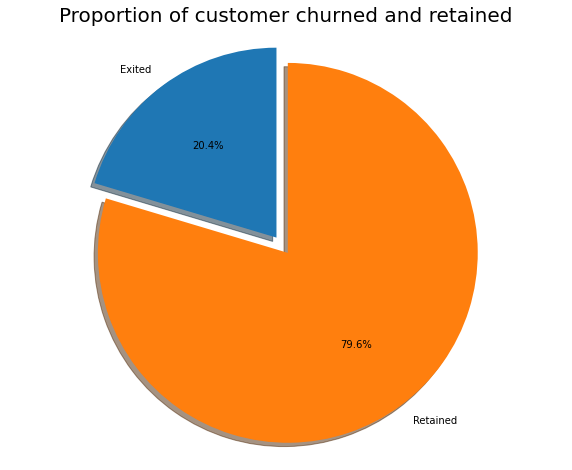

In [ ]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

So about 20% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn. Given 20% is a small number, we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

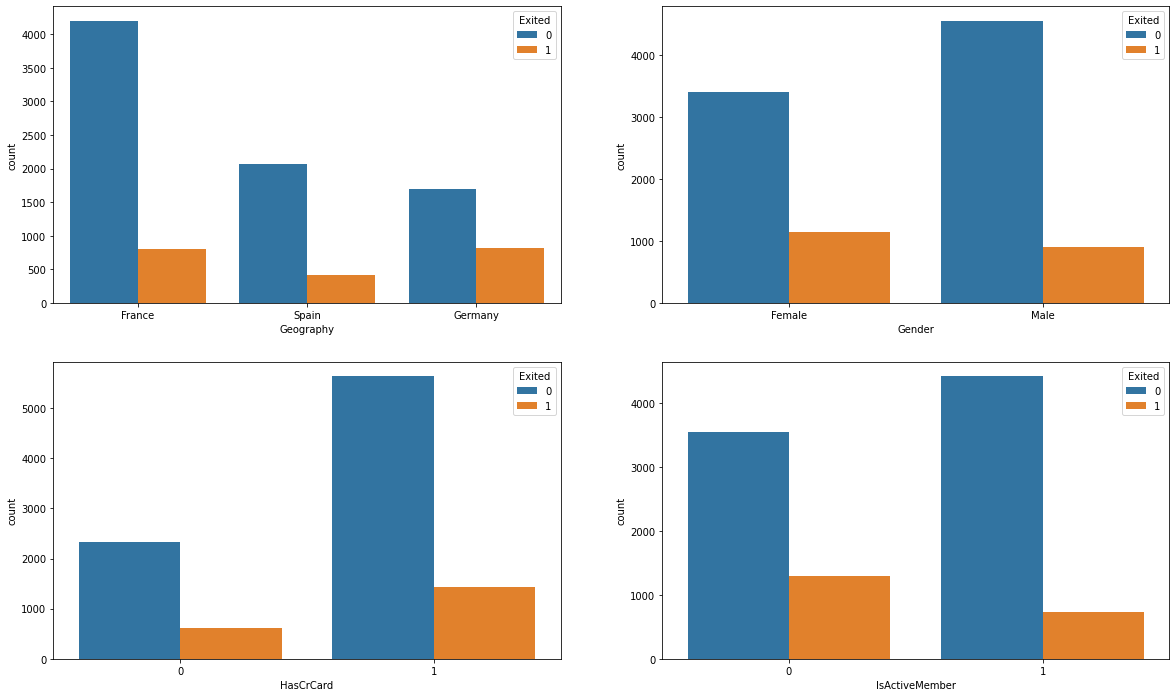

In [ ]:
# We first review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

We note the following:

i) Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.</br>
ii) The proportion of female customers churning is also greater than that of male customers</br>
iii) Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.</br>
iv) Unsurprisingly the inactive members have a greater churn. Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn.

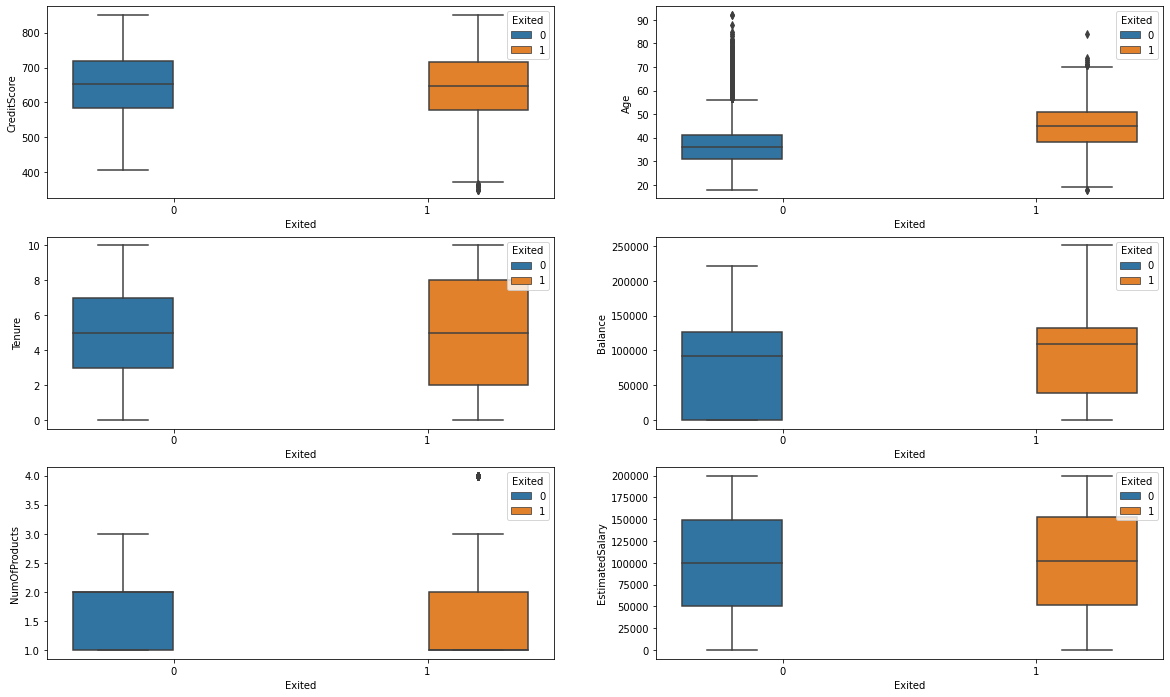

In [ ]:
 # Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

We note the following:

i) There is no significant difference in the credit score distribution between retained and churned customers.</br>
ii) The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups</br>
iii) With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.</br>
iv) Worryingly, the bank is losing customers with significant bank balances which is likely to hit their available capital for lending.</br>
v) Neither the product nor the salary has a significant effect on the likelihood to churn.

### 4. Feature engineering

We seek to add features that are likely to have an impact on the probability of churning. We first split the train and test sets

In [ ]:
# Split Train, test data
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

8000
2000


In [ ]:
df_train['BalanceSalaryRatio'] = df_train.Balance/df_train.EstimatedSalary
df_train['CreditScoreGivenAge'] = df_train.CreditScore/(df_train.Age)
df_train['TenureByAge'] = df_train.Tenure/(df_train.Age)

In [ ]:
# Resulting Data Frame
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,CreditScoreGivenAge,TenureByAge
8159,461,Spain,Female,25,6,0.00,2,1,1,15306.29,0,0.000000,18.440000,0.240000
6332,619,France,Female,35,4,90413.12,1,1,1,20555.21,0,4.398550,17.685714,0.114286
8895,699,France,Female,40,8,122038.34,1,1,0,102085.35,0,1.195454,17.475000,0.200000
5351,558,Germany,Male,41,2,124227.14,1,1,1,111184.67,0,1.117305,13.609756,0.048780
4314,638,France,Male,34,5,133501.36,1,0,1,155643.04,0,0.857741,18.764706,0.147059


### 5. Data prep for model fitting

In [ ]:
# Arrange columns by data type for easier manipulation

continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df_train = df_train[['Exited'] + continuous_vars + cat_vars]
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,0,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,0,1,France,Male


For the one hot variables, we change 0 to -1 so that the models can capture a negative relation 
where the attribute in inapplicable instead of 0

In [ ]:
df_train.loc[df_train.HasCrCard == 0, 'HasCrCard'] = -1
df_train.loc[df_train.IsActiveMember == 0, 'IsActiveMember'] = -1
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,France,Male


In [ ]:
# One hot encode the categorical variables
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df_train[i].dtype == np.str or df_train[i].dtype == np.object):
        for j in df_train[i].unique():
            df_train[i+'_'+j] = np.where(df_train[i] == j,1,-1)
        remove.append(i)
df_train = df_train.drop(remove, axis=1)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,1,-1,-1,1,-1
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,-1,1,-1,1,-1
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,-1,1,-1,1,-1
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,-1,-1,1,-1,1
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,-1,1,-1,-1,1


In [ ]:
# minMax scaling the continuous variables
minVec = df_train[continuous_vars].min().copy()
maxVec = df_train[continuous_vars].max().copy()
df_train[continuous_vars] = (df_train[continuous_vars]-minVec)/(maxVec-minVec)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,0.222,0.094595,0.6,0.000000,0.333333,0.076118,0.000000,0.432000,0.323157,1,1,1,-1,-1,1,-1
6332,0,0.538,0.229730,0.4,0.360358,0.000000,0.102376,0.003317,0.205714,0.305211,1,1,-1,1,-1,1,-1
8895,0,0.698,0.297297,0.8,0.486406,0.000000,0.510225,0.000901,0.360000,0.300198,1,-1,-1,1,-1,1,-1
5351,0,0.416,0.310811,0.2,0.495130,0.000000,0.555744,0.000843,0.087805,0.208238,1,1,-1,-1,1,-1,1
4314,0,0.576,0.216216,0.5,0.532094,0.000000,0.778145,0.000647,0.264706,0.330882,-1,1,-1,1,-1,-1,1


In [ ]:
# data prep pipeline for test data
def DfPrepPipeline(df_predict,df_train_Cols,minVec,maxVec):
    # Add new features
    df_predict['BalanceSalaryRatio'] = df_predict.Balance/df_predict.EstimatedSalary
    df_predict['TenureByAge'] = df_predict.Tenure/(df_predict.Age - 18)
    df_predict['CreditScoreGivenAge'] = df_predict.CreditScore/(df_predict.Age - 18)
    # Reorder the columns
    continuous_vars = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
    cat_vars = ['HasCrCard','IsActiveMember',"Geography", "Gender"] 
    df_predict = df_predict[['Exited'] + continuous_vars + cat_vars]
    # Change the 0 in categorical variables to -1
    df_predict.loc[df_predict.HasCrCard == 0, 'HasCrCard'] = -1
    df_predict.loc[df_predict.IsActiveMember == 0, 'IsActiveMember'] = -1
    # One hot encode the categorical variables
    lst = ["Geography", "Gender"]
    remove = list()
    for i in lst:
        for j in df_predict[i].unique():
            df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
        remove.append(i)
    df_predict = df_predict.drop(remove, axis=1)
    # Ensure that all one hot encoded variables that appear in the train data appear in the subsequent data
    L = list(set(df_train_Cols) - set(df_predict.columns))
    for l in L:
        df_predict[str(l)] = -1        
    # MinMax scaling coontinuous variables based on min and max from the train data
    df_predict[continuous_vars] = (df_predict[continuous_vars]-minVec)/(maxVec-minVec)
    # Ensure that The variables are ordered in the same way as was ordered in the train set
    df_predict = df_predict[df_train_Cols]
    return df_predict

df_test = DfPrepPipeline(df_test,df_train.columns,minVec,maxVec)
df_test = df_test.mask(np.isinf(df_test))
df_test = df_test.dropna()
df_test.shape

(1996, 17)

## 6. Test-train-validation split

In [ ]:
# extract numpy arrays of test train data
x_train = df_train.iloc[:,1:].values
y_train = df_train.iloc[:,0].values
X_test = df_test.iloc[:,1:].values
Y_test = df_test.iloc[:,0].values

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.25)
print(X_train.shape, X_val.shape,X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(6000, 16) (2000, 16) (1996, 16) (6000,) (2000,) (1996,)


### 6. Model fitting and selection for best optimizer

For the model fitting, I try out the Artificial Neural Network with different optimizers and different learning rates.</br>


In [ ]:
# write your own network

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(16, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x

Mainly I used three types of learning rates:<br>
i) low </br>


In [ ]:
low_lr = 10**(-5)

ii) moderate </br>


In [ ]:
mod_lr = 10**(-3)

iii) high </br>


In [ ]:
high_lr = 0.1

Now the training part :

In [ ]:
def train_network(optim = 'SGD',learning_rate = mod_lr,loss = nn.CrossEntropyLoss(),seed = 0,num_epochs = 100,batch_size = 50,X_train = X_train, Y_train = Y_train,X_val = X_val,Y_val = Y_val):
    from sklearn.utils import shuffle
    from torch.autograd import Variable

    # Loss function and optimizers
    
    net = Net()
    lr = learning_rate 
    criterion = loss

    if optim == 'SGD with momentum':
        optimizer = torch.optim.SGD(net.parameters(),lr = lr,momentum = 0.9)
    elif optim == 'Adagrad':
        optimizer = torch.optim.Adagrad(net.parameters(),lr = lr)
    elif optim == 'RMSprop':
        optimizer = torch.optim.RMSprop(net.parameters(),lr = lr)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(),lr = lr)
    else:
        optimizer = torch.optim.SGD(net.parameters(),lr = lr)   
    

    # Fix the hyper parameters

    batch_size = batch_size
    num_epochs = num_epochs
    batch_no = len(X_train) // batch_size
    batch_no_val = len(X_val) // batch_size

    bias_grads1 = []
    weight_grads1 = []
    bias_grads2 = []
    weight_grads2 = []
    T_Loss = []
    T_Acc = []
    V_Loss = []
    V_Acc = []

    torch.manual_seed(seed)

    for epoch in range(num_epochs):
      
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        samples = 0
        samples_ = 0

        X_train, Y_train = shuffle(X_train, Y_train)
        # Mini batch learning
        net.train()
        for i in range(batch_no):
            start = i * batch_size
            end = start + batch_size
            x_var = Variable(torch.FloatTensor(X_train[start:end]))
            y_var = Variable(torch.LongTensor(Y_train[start:end]))
            
            ypred_var = net(x_var)
            loss = criterion(ypred_var, y_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()*y_var.size(0)

            weight_grads1.append(np.linalg.norm(net.fc1.weight.grad.cpu().numpy()))
            bias_grads1.append(np.linalg.norm(net.fc1.bias.grad.cpu().numpy()))
            weight_grads2.append(np.linalg.norm(net.fc2.weight.grad.cpu().numpy()))
            bias_grads2.append(np.linalg.norm(net.fc2.bias.grad.cpu().numpy()))

            values, labels = torch.max(ypred_var, 1)
            num_right = np.sum(labels.data.numpy() == Y_train[start:end])
            train_acc += num_right
            samples += y_var.size(0)

        T_Loss.append(train_loss/samples) 
        T_Acc.append(train_acc/samples)

        # Evaluate the model
        net.eval()
        with torch.no_grad():
            X_val, Y_val = shuffle(X_val, Y_val)
            
            # Mini batch validation
            for i in range(batch_no_val):
                start = i * batch_size
                end = start + batch_size
                x_val_var = Variable(torch.FloatTensor(X_val[start:end]))
                y_val_var = Variable(torch.LongTensor(Y_val[start:end]))

                ypred_val = net(x_val_var)
                
                loss_ = criterion(ypred_val, y_val_var)
                valid_loss += loss_.item()*y_val_var.size(0)
                
                values_, labels_ = torch.max(ypred_val, 1)
                num_right_ = np.sum(labels_.data.numpy() == Y_val[start:end])
                valid_acc += num_right_
                samples_ += y_val_var.size(0)
        
        V_Loss.append(valid_loss/samples_)
        V_Acc.append(valid_acc/samples_)

        print(f'\nEpoch: {epoch+1} \tTraining Loss: {train_loss/samples:.4f} \tTraining Accuracy: {train_acc/samples:.4f} \tValidation Loss: {valid_loss/samples_:.4f} \tValidation Accuracy: {valid_acc/samples_:.4f}')
    
    #torch.save(model.state_dict(), save_file_name)
    output = (bias_grads1,weight_grads1,bias_grads2,weight_grads2,T_Loss,T_Acc,V_Loss,V_Acc)
    return output

Define a function to visualize the outputs.

In [ ]:
def plotEverything(output,optimizer_name = 'SGD', learning_rate = '0.01'):
    a,b,c,d,e,f,g,h = output
    plt.figure(figsize = (25,10))
    plt.subplot(2,3,1)
    plt.plot(e,label="Training loss")
    plt.plot(g,label="Validation loss")
    plt.title("Loss curve in " + optimizer_name + ": (lr = " + learning_rate + ")")
    plt.legend()
    
    plt.subplot(2,3,4)
    plt.plot(f,label="Training accuracy")
    plt.plot(h,label="Validation accuracy")
    plt.title("Accuracy curve in " + optimizer_name + ": (lr = " + learning_rate + ")")
    plt.legend()

    plt.subplot(2,3,2)
    sns.kdeplot(b, shade=True)
    sns.kdeplot(a, shade=True)
    plt.legend(['weight','bias'])
    plt.xlim(0)
    plt.title("Distribution of the gradients in the first layer in " + optimizer_name + ": (lr = " + learning_rate + ")")

    plt.subplot(2,3,5)
    sns.kdeplot(d, shade=True)
    sns.kdeplot(c, shade=True)
    plt.legend(['weight','bias'])
    plt.xlim(0)
    plt.title("Distribution of the gradients in the second layer in " + optimizer_name + ": (lr = " + learning_rate + ")")

    plt.subplot(2,3,3)
    plt.scatter(np.arange(0,len(b)),b, label = 'weight')
    plt.scatter(np.arange(0,len(a)),a, label = 'bias')
    plt.title('Change in the norm of gradients in the first layer in ' + optimizer_name + ": (lr = " + learning_rate + ")")
    plt.legend()

    plt.subplot(2,3,6)
    plt.scatter(np.arange(0,len(d)),d,label="weight")
    plt.scatter(np.arange(0,len(c)),c,label="bias")
    plt.title("Change in the norm of gradients in the second layer in " + optimizer_name + ": (lr = " + learning_rate + ")")
    plt.legend()



##7. Experiments with different optimizers and learning rates

I tried different optimizers:<br>
i) SGD <br>

Originally we are using Mini-Batch gradient descent here. Mini-Batch gradient decent integrates the advantages of batch gradient decent and stochastic gradient decent, and update the parameters after obtaining the gradient of a mini-batch of samples:
$$x_{k+1} = x_{k} − t_{k}\nabla f(x_{k})^{(i:i+m)}$$
where the mini-batch size is m.<br>
Mini-batch gradient decent can not guarantee good convergence, and the tuning of step size also need some experience. Therefore some researchers extend it with some more useful tricks and techniques to improve the convergence which we will see. For convenience, people also call mini-batch gradient decent as SGD.


In [ ]:
output_sgd_low = train_network(learning_rate = low_lr)

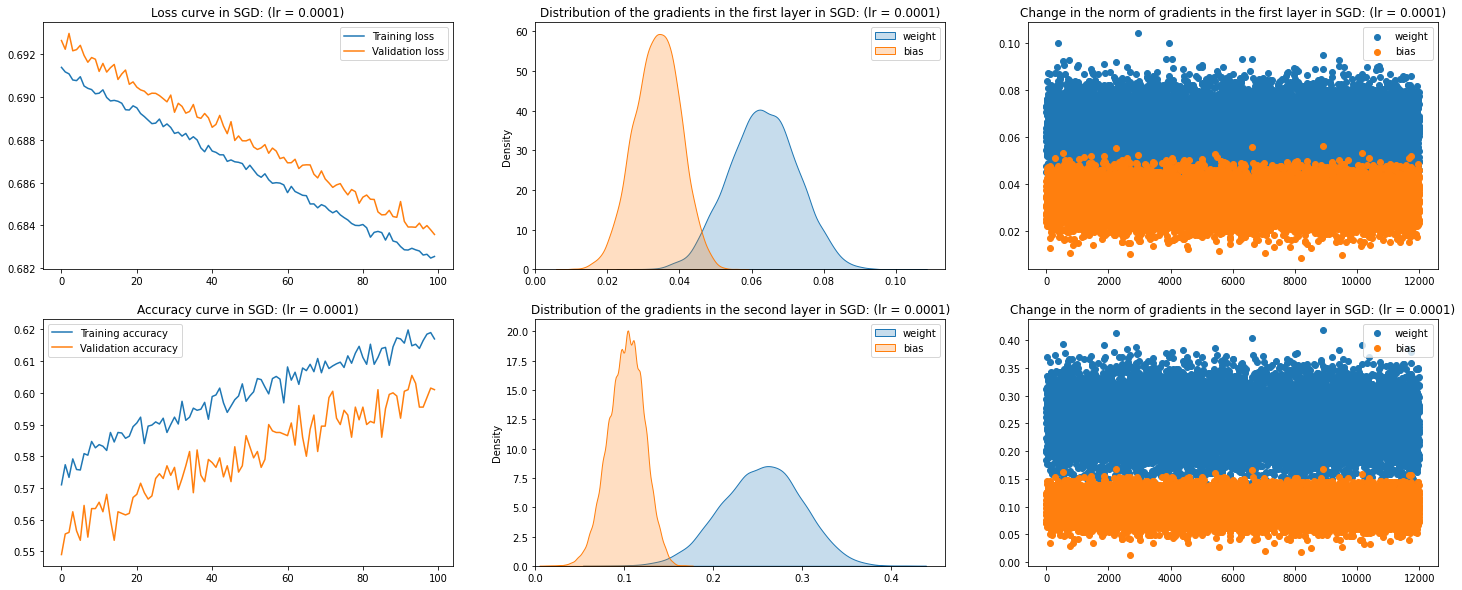

In [ ]:
plotEverything(output_sgd_low,'SGD','0.0001')

In [ ]:
output_sgd_mod = train_network(learning_rate = mod_lr)

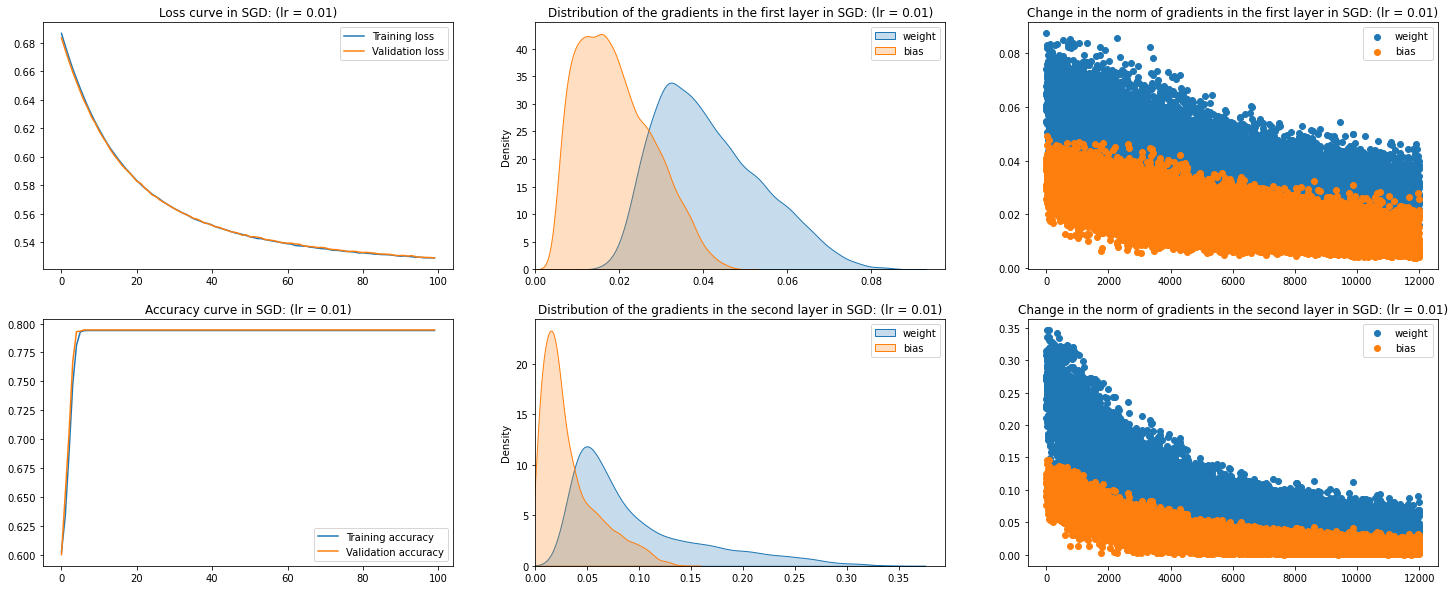

In [ ]:
plotEverything(output_sgd_mod,'SGD','0.01')

In [ ]:
output_sgd_high = train_network(learning_rate = high_lr)

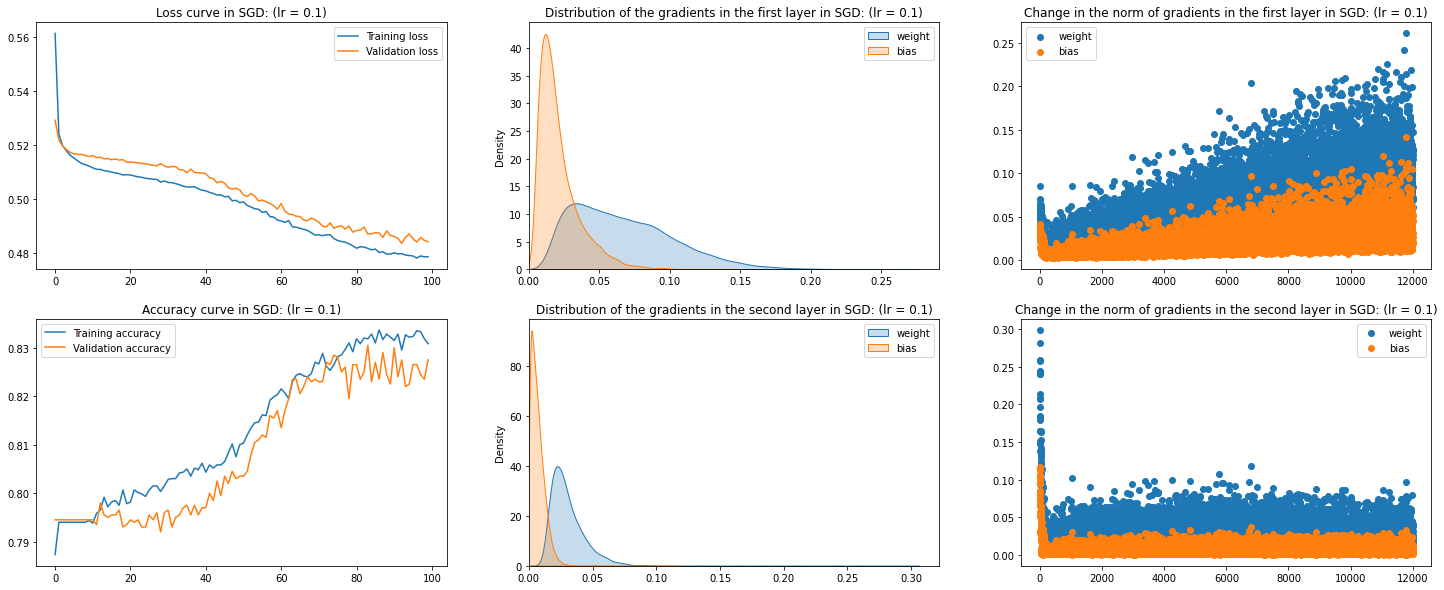

In [ ]:
plotEverything(output_sgd_high,'SGD','0.1')

ii) SGD with momentum

If there is a long shallow ravine with steep walls on the direction to the optimal point, then the standard SGD will tend to oscillate across the narrow ravine. Momentum is one of the mechanism which is used to fix the direction:
$$v_{k} = mv_{k−1} + t_{k}\nabla f(x_{k}) ;\;\;\; x_{k+1} = x_{k} − v_{k}$$

where m ∈ (0, 1] determines for how many iterations the previous gradients are incorporated into the current update. Generally m is set to 0.5 until the initial learning stabilizes and then is increased to 0.9 or higher.

In [ ]:
output_sgdm_low = train_network('SGD with momentum',low_lr)

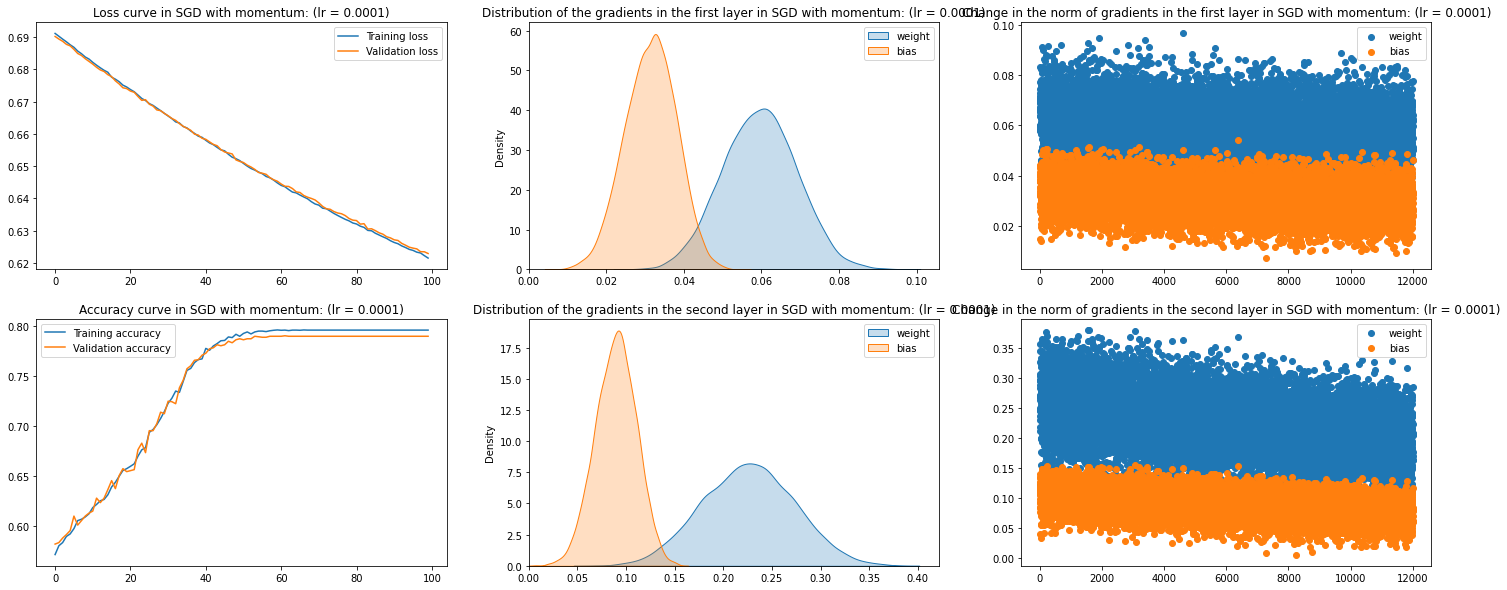

In [ ]:
plotEverything(output_sgdm_low,'SGD with momentum','0.0001')

In [ ]:
output_sgdm_mod = train_network('SGD with momentum')

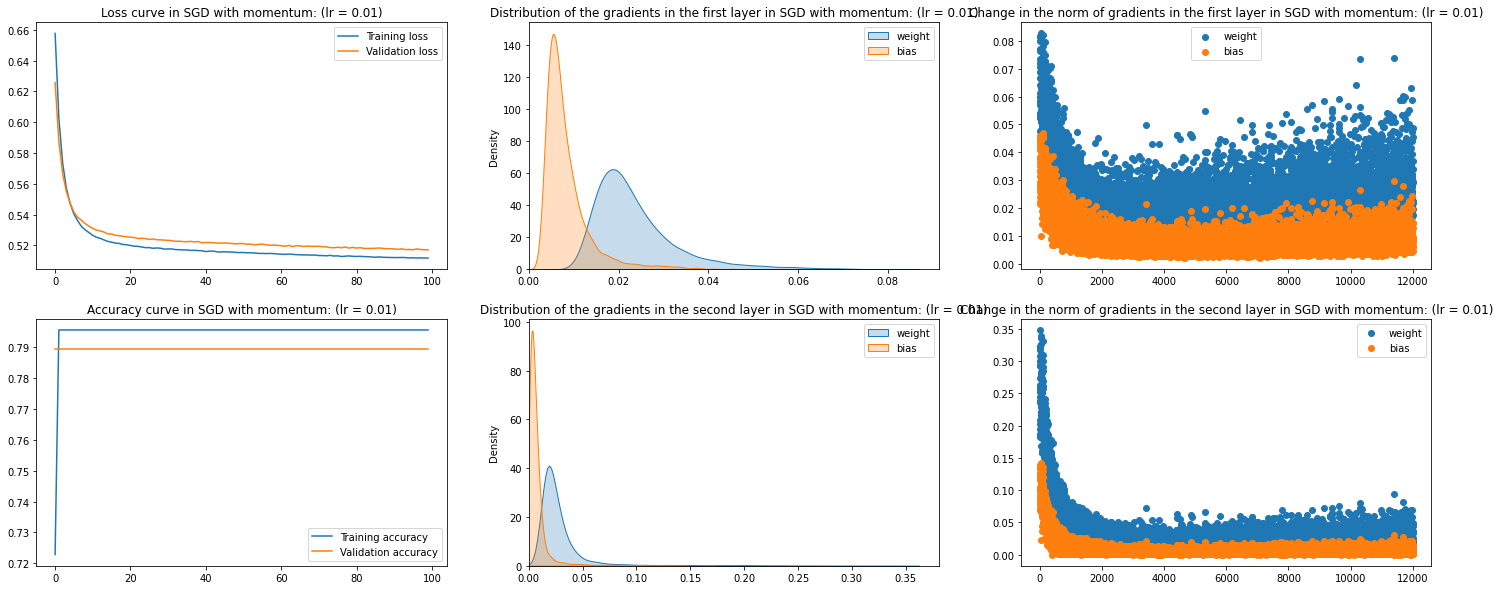

In [ ]:
plotEverything(output_sgdm_mod,'SGD with momentum','0.01')

In [ ]:
output_sgdm_high = train_network('SGD with momentum',high_lr)

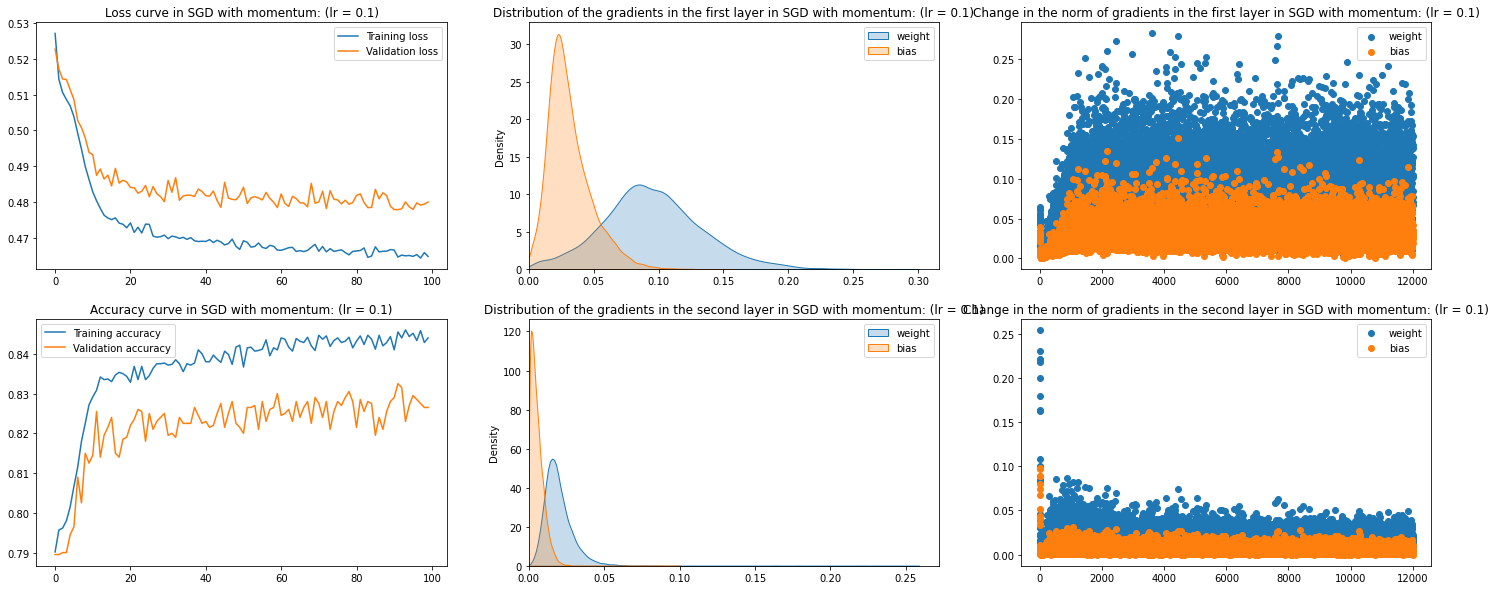

In [ ]:
plotEverything(output_sgdm_high,'SGD with momentum','0.1')

iii) Adagrad <br>

Adagrad scales the step size for each parameter according to the history of gradients for that parameter which is basically done by dividing current gradient in update rule by the sum of previous gradients:
$$G_{k} = G_{k−1} + \nabla f(x_{k})^{2} ;\;\;\; x_{k+1} = x_{k} − \frac{t}{\sqrt{G_{k} + \epsilon}}\nabla f(x_{k})$$

where G is the accumulation of the history gradients, and $\epsilon$ is a smoothing term that avoids division by
zero (can be 1e − 6). The step size is different for each of the parameters. It is greater for parameters
where the historical gradients were small (since G is small) and the rate is small whenever historical
gradients were relatively big. Therefore, we need not to manually tune the step size t. We can use
a default value of 0.01. But when accumulation G becomes larger, the step size will reach zero at
infinity. So the following methods are proposed.

In [ ]:
output_adgd_low = train_network('Adagrad',low_lr)

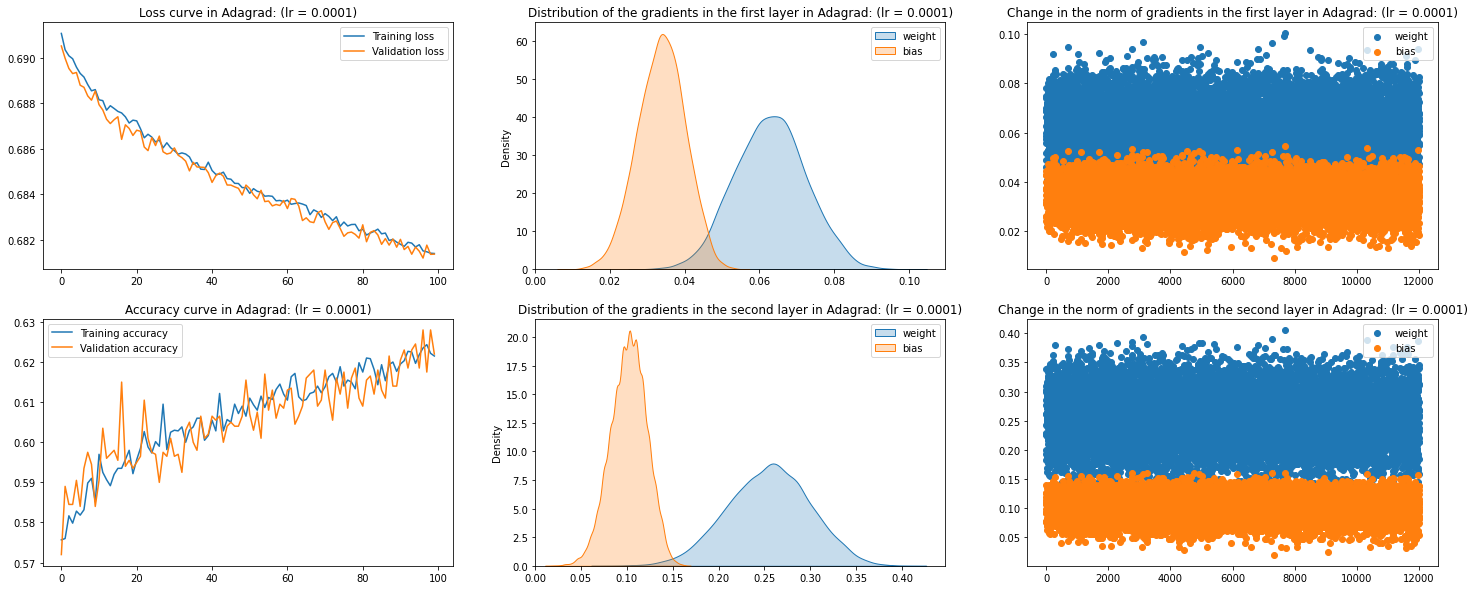

In [ ]:
plotEverything(output_adgd_low,'Adagrad','0.0001')

In [ ]:
output_adgd_mod = train_network('Adagrad')

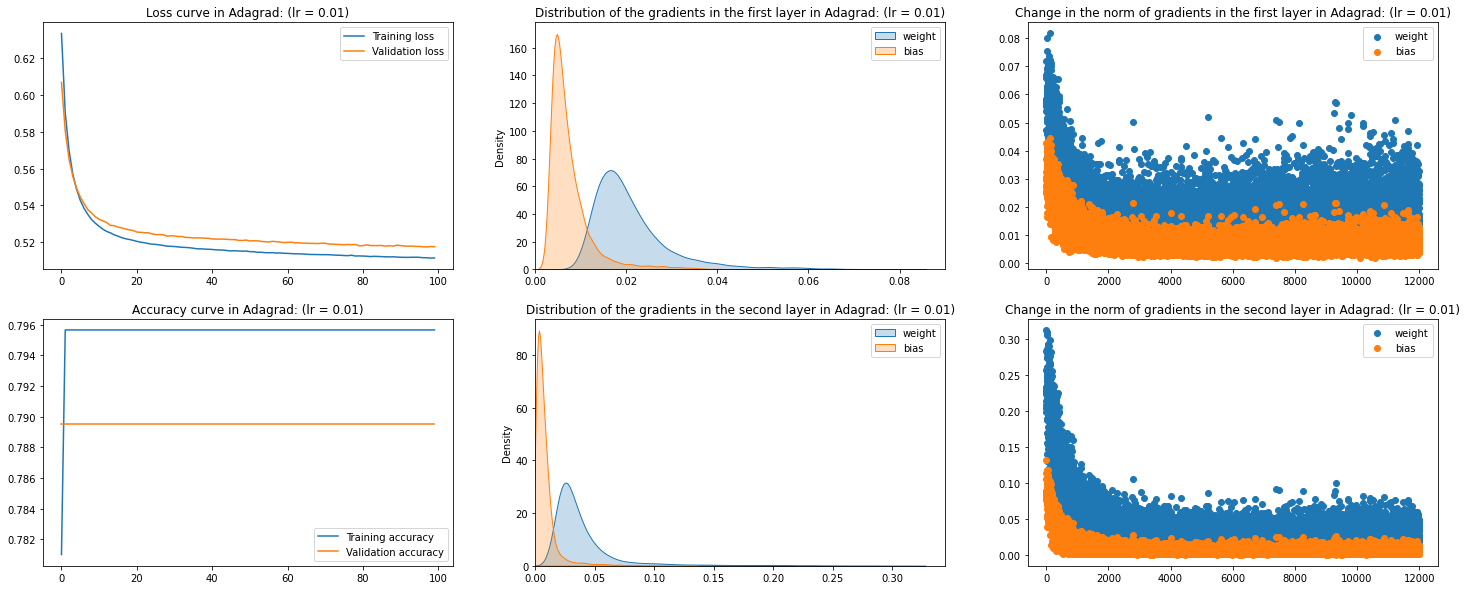

In [ ]:
plotEverything(output_adgd_mod,'Adagrad','0.01')

In [ ]:
output_adgd_high = train_network('Adagrad',high_lr)

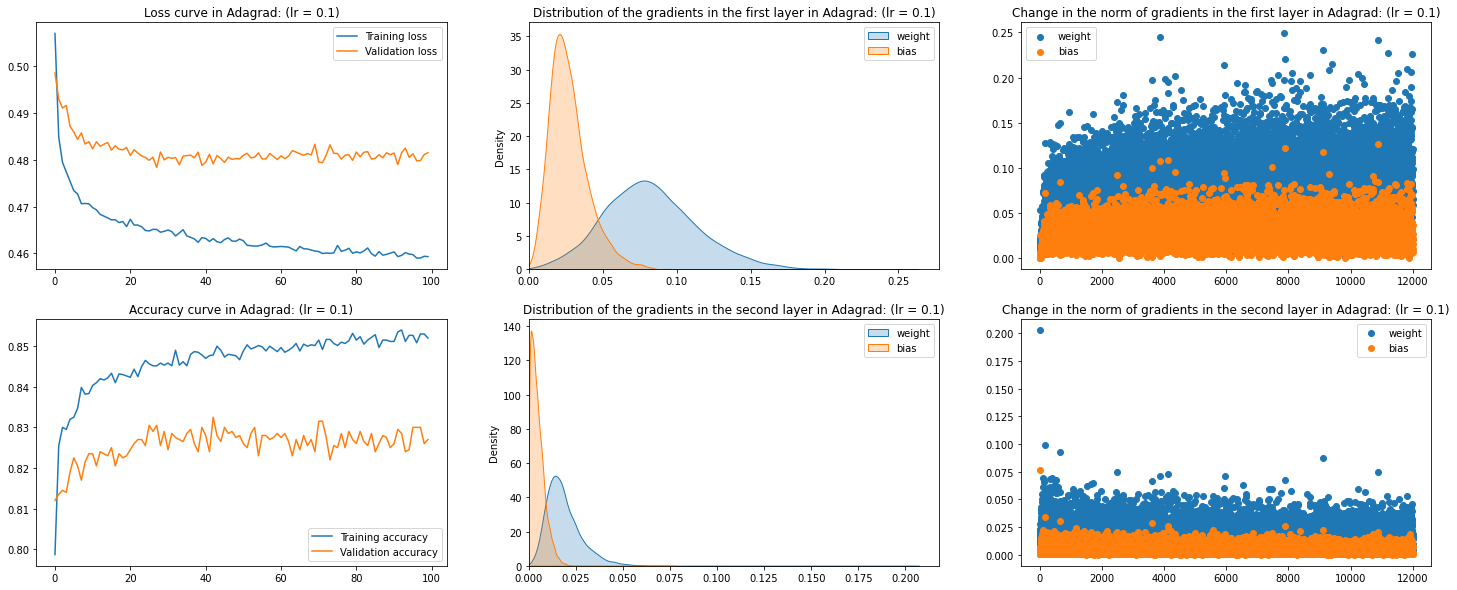

In [ ]:
plotEverything(output_adgd_high,'Adagrad','0.1')

iv) RMSprop <br>

RMSprop is proposed to tackle the problem of step size vanishing of Adagrad. It employs the decaying average of the history gradients:

$$E[\nabla f(x)^{2}]_{k} = \rho E[\nabla f(x)^{2}]_{k−1} + (1 − \rho)\nabla f(x_{k})^{2} $$
$$x_{k+1} = x_{k} − \frac{t}{\sqrt{E[\nabla f(x)2]_{k} + \epsilon}}\nabla f(x_{k})$$

where $\rho$ is a decay constant (e.g., 0.9).

In [ ]:
output_rms_low = train_network('RMSprop', low_lr)

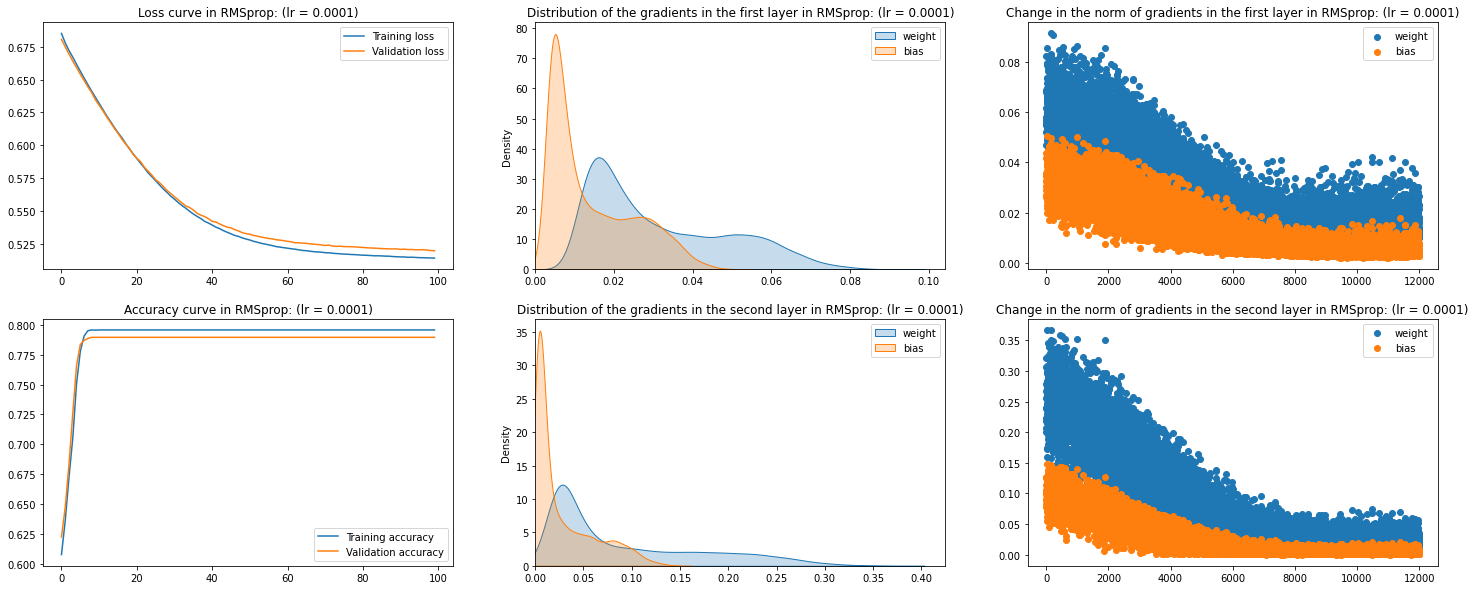

In [ ]:
plotEverything(output_rms_low,'RMSprop','0.0001')

In [ ]:
output_rms_mod = train_network('RMSprop')

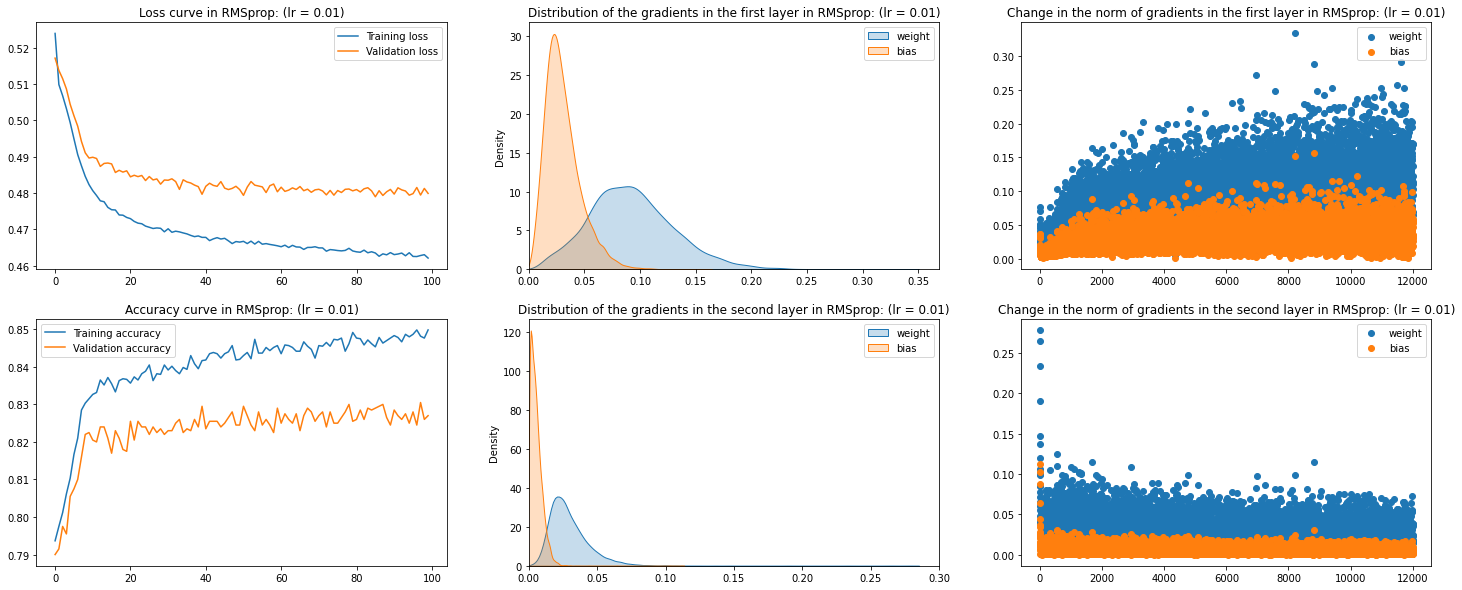

In [ ]:
plotEverything(output_rms_mod,'RMSprop','0.01')

In [ ]:
output_rms_high = train_network('RMSprop',high_lr)

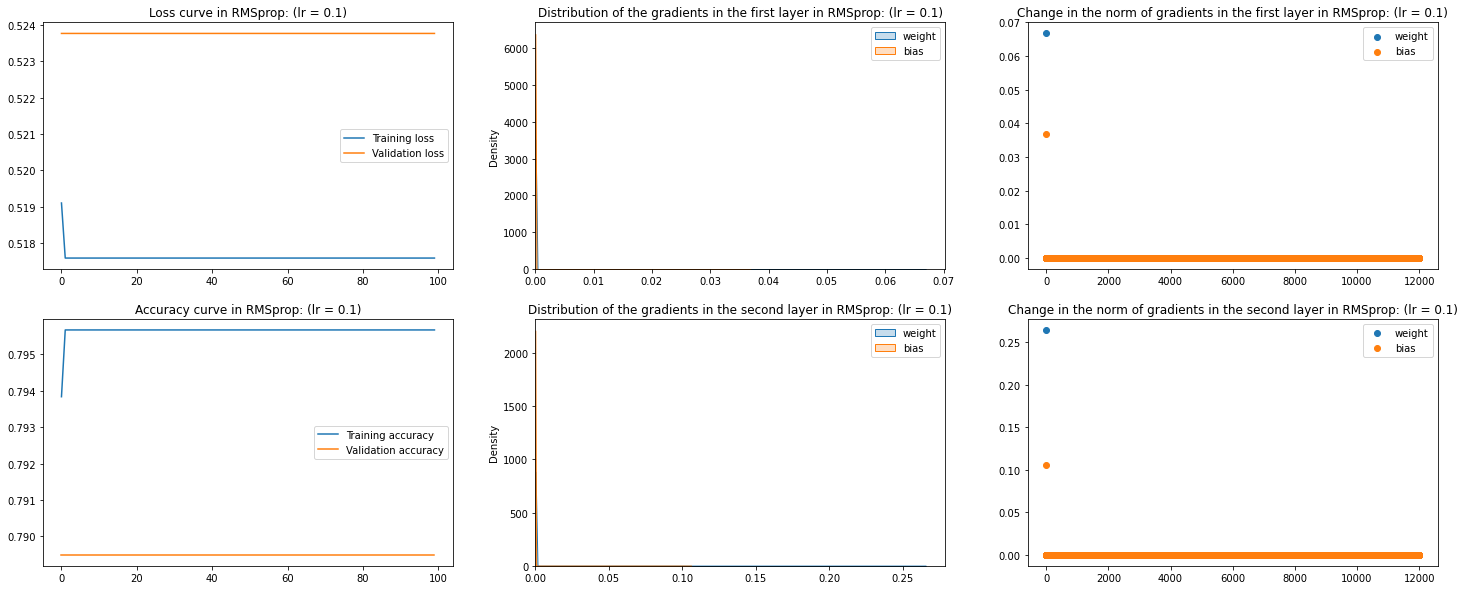

In [ ]:
plotEverything(output_rms_high,'RMSprop','0.1')

v) Adam <br>

Adam optimization algorithm is an extension to stochastic gradient descent. It was presented in 2015.The name **Adam** is derived from **Adaptive moment estimation**.The authors describe Adam as combining the advantages of two other extensions of stochastic gradient descent algorithm.

Adam is another method that computes adaptive step size for each parameter. It uses both the decaying average of history gradients and their squared values. Adam update rule consists of the
following steps:

$$m_{k} = \beta_{1}m_{k−1} + (1 − \beta_{1})\nabla f(x_{k})$$
$$v_{k} = \beta_{2}v_{k−1} + (1 − \beta_{2})\nabla f(x_{k})^{2}$$
$$\hat{m}_{k} = \frac{m_{k}}{1 − \beta_{k}^{1}} ;\;\; \hat{v}_{k} = \frac{v_{k}}{1 − \beta_{k}^{2}}$$
$$x_{k+1} = x_{k} − \frac{t}{\sqrt{\hat{v}_{k} + \epsilon}}\hat{m}_{k}$$

where $\beta_{1}$ can be 0.9, $\beta_{2}$ can be 0.999, and $\epsilon$ can be 1e − 8.

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).



In [ ]:
output_adam_low = train_network('Adam',low_lr)

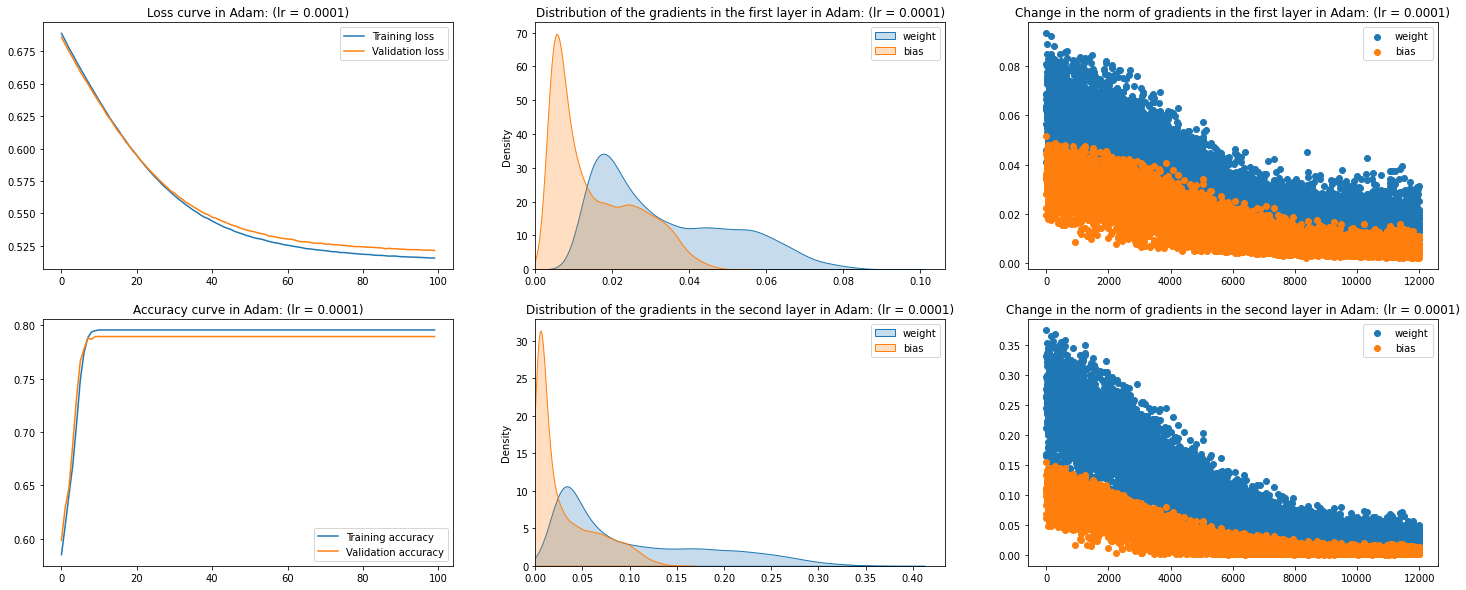

In [ ]:
plotEverything(output_adam_low,'Adam','0.0001')

In [ ]:
output_adam_mod = train_network('Adam')

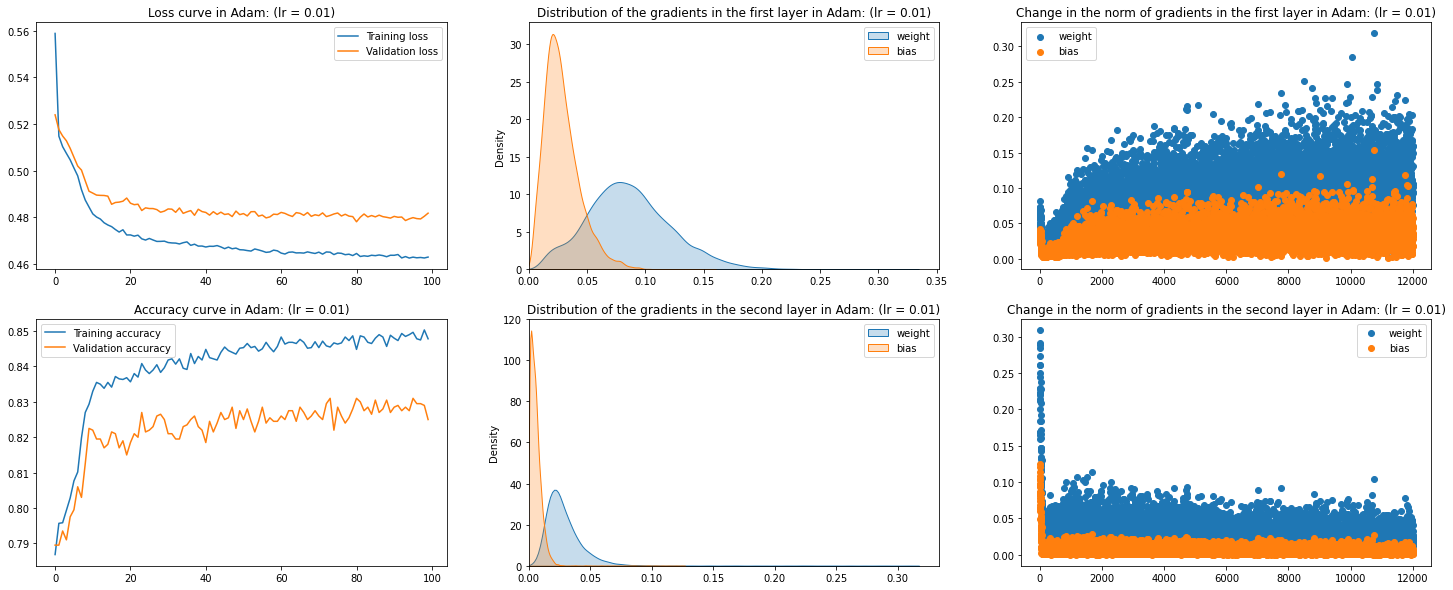

In [ ]:
plotEverything(output_adam_mod,'Adam','0.01')

In [ ]:
output_adam_high = train_network('Adam', high_lr)

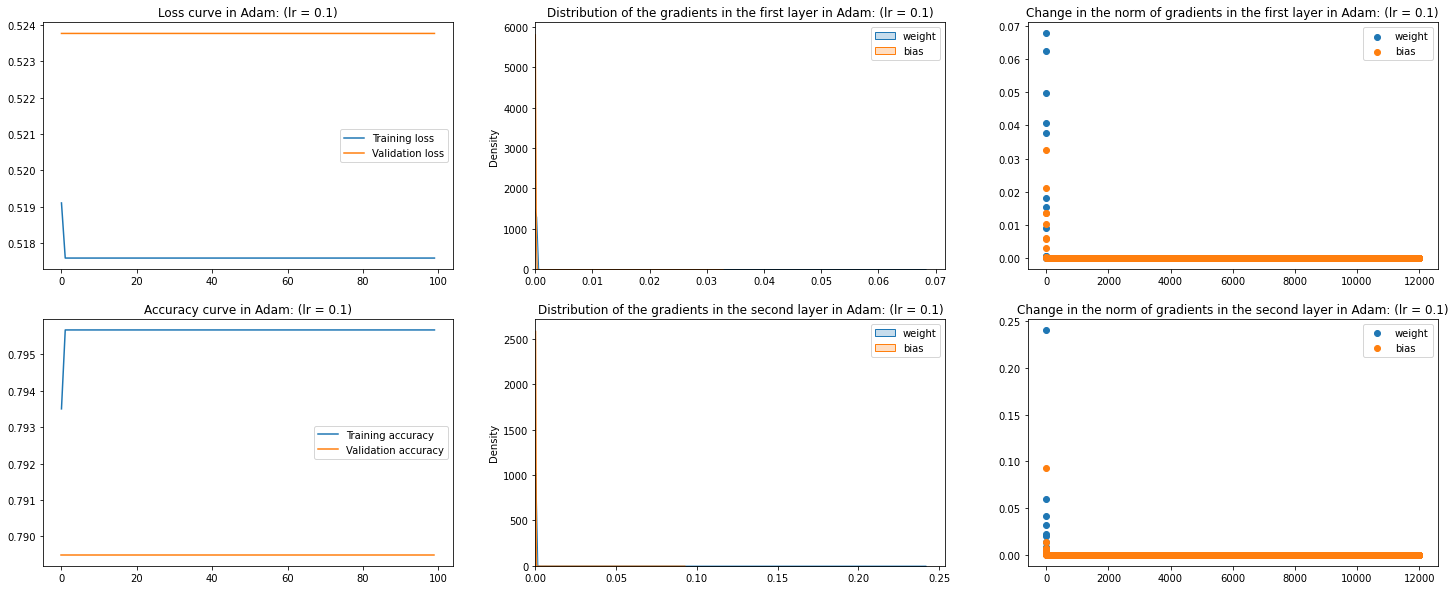

In [ ]:
plotEverything(output_adam_high,'Adam','0.1')

In [2]:
Optimizers = ['SGD','SGD with momentum','Adagrad','RMSprop','Adam']
Training_Loss = [0.6825,0.6448,0.6814,0.6412,0.6370]
Training_Accuracy = [0.6190,0.7958,0.6222,0.7957,0.7957]
Test_Loss = [0.6838,0.6453,0.6814,0.6401,0.6357]
Test_Accuracy = [0.6015,0.7895,0.6280,0.7895,0.7895]
Epochs_Required = [99,60,99,9,11]

dict = {'Optimizers' : Optimizers, 'Training_Loss' : Training_Loss, 'Training_Accuracy' : Training_Accuracy, 'Test_Loss' : Test_Loss, 'Test_Accuracy' : Test_Accuracy, 'Epochs_Required' : Epochs_Required}
low = pd.DataFrame(dict)

print('Loss-accuracy for low learning rate (0.0001):')
low

Loss-accuracy for low learning rate (0.0001):


,Optimizers,Training_Loss,Training_Accuracy,Test_Loss,Test_Accuracy,Epochs_Required
0,SGD,0.6825,0.6190,0.6838,0.6015,99
1,SGD with momentum,0.6448,0.7958,0.6453,0.7895,60
2,Adagrad,0.6814,0.6222,0.6814,0.6280,99
3,RMSprop,0.6412,0.7957,0.6401,0.7895,9
4,Adam,0.6370,0.7957,0.6357,0.7895,11


In [3]:
Optimizers = ['SGD','SGD with momentum','Adagrad','RMSprop','Adam']
Training_Loss = [0.6352,0.5301,0.5303,0.4625,0.4625]
Training_Accuracy = [0.7940,0.7957,0.7957,0.8498,0.8503]
Test_Loss = [0.6340,0.5341,0.5338,0.4816,0.4804]
Test_Accuracy = [0.7945,0.7895,0.7895,0.8245,0.8290]
Epochs_Required = [8,9,10,97,99]

dict = {'Optimizers' : Optimizers, 'Training_Loss' : Training_Loss, 'Training_Accuracy' : Training_Accuracy, 'Test_Loss' : Test_Loss, 'Test_Accuracy' : Test_Accuracy, 'Epochs_Required' : Epochs_Required}
mod = pd.DataFrame(dict)

print('Loss-accuracy for moderate learning rate (0.01):')
mod

Loss-accuracy for moderate learning rate (0.01):


,Optimizers,Training_Loss,Training_Accuracy,Test_Loss,Test_Accuracy,Epochs_Required
0,SGD,0.6352,0.7940,0.6340,0.7945,8
1,SGD with momentum,0.5301,0.7957,0.5341,0.7895,9
2,Adagrad,0.5303,0.7957,0.5338,0.7895,10
3,RMSprop,0.4625,0.8498,0.4816,0.8245,97
4,Adam,0.4625,0.8503,0.4804,0.8290,99


In [4]:
Optimizers = ['SGD','SGD with momentum','Adagrad','RMSprop','Adam']
Training_Loss = [0.5241,0.4652,0.4596,0.5176,0.5176]
Training_Accuracy = [0.7940,0.8480,0.8540,0.7957,0.7957]
Test_Loss = [0.5281,0.4803,0.4815,0.5238,0.5238]
Test_Accuracy = [0.7945,0.8230,0.8285,0.7895,0.7895]
Epochs_Required = [2,94,93,2,2]

dict = {'Optimizers' : Optimizers, 'Training_Loss' : Training_Loss, 'Training_Accuracy' : Training_Accuracy, 'Test_Loss' : Test_Loss, 'Test_Accuracy' : Test_Accuracy, 'Epochs_Required' : Epochs_Required}
high = pd.DataFrame(dict)

print('Loss-accuracy for high learning rate (1.0):')
high

Loss-accuracy for high learning rate (1.0):


,Optimizers,Training_Loss,Training_Accuracy,Test_Loss,Test_Accuracy,Epochs_Required
0,SGD,0.5241,0.7940,0.5281,0.7945,2
1,SGD with momentum,0.4652,0.8480,0.4803,0.8230,94
2,Adagrad,0.4596,0.8540,0.4815,0.8285,93
3,RMSprop,0.5176,0.7957,0.5238,0.7895,2
4,Adam,0.5176,0.7957,0.5238,0.7895,2
